In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
# import required libraries
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [4]:
# Read data
file = 'drive/My Drive/Colab Notebooks/42_ai_piscine/input/Transactions.csv'
df = pd.read_csv(file)
df.head()

,Unnamed: 0.1,Unnamed: 0,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD_SCENARIO
0,0,0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,Legitimate Transaction
1,1,1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,Legitimate Transaction
2,2,2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,Fraudulent Transaction Internet
3,3,3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,Legitimate Transaction
4,4,4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,Legitimate Transaction


In [6]:
def plot_fraud_scenario_counts(data_frame):
    """
    Plots the counts of transactions for different fraud scenarios.

    :param data_frame: The DataFrame containing the data.
    """
    fraud_scenarios = data_frame['TX_FRAUD_SCENARIO'].value_counts().sort_index()
    fraud_scenarios.index.name = 'Fraud Scenario'

    fig = px.bar(
        fraud_scenarios, x=fraud_scenarios.index, y=fraud_scenarios.values, color=fraud_scenarios.index,
    )
    fig.update_layout(
        xaxis_title='Fraud Scenario',
        yaxis_title='Number of Transactions',
    )
    fig.show()

# Call the function to plot fraud scenario counts (GitHub does not support interactive plot)
plot_fraud_scenario_counts(df)

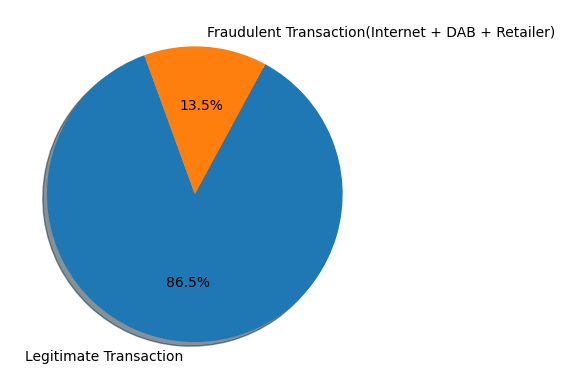

In [ ]:
def plot_data_imbalance(data_frame, target_column):
    """
    Display a pie chart to illustrate class imbalance in the target column.

    :param data_frame: The DataFrame containing the data.
    :param target_column: The name of the target column for which the imbalance should be illustrated.
    """
    if target_column not in data_frame.columns:
        raise ValueError(f"Target column '{target_column}' not found in the DataFrame.")

    class_counts = data_frame[target_column].value_counts()

    class_counts_df = class_counts.reset_index()
    class_counts_df.columns = [target_column, 'Count']

    frauds_count = 0
    legitimate_count = 0
    for index, row in class_counts_df.iterrows():
        if row['TX_FRAUD_SCENARIO'] in ['Fraudulent Transaction Internet', 'Fraudulent Transaction DAB', 'Fraudulent Transaction retailer']:
            frauds_count += row['Count']
        elif row['TX_FRAUD_SCENARIO'] == 'Legitimate Transaction':
            legitimate_count = row['Count']

    combined_class_counts_df = pd.DataFrame({
        'Fraud Scenario': ['Legitimate Transaction', 'Fraudulent Transaction(Internet + DAB + Retailer)'],
        'Count': [legitimate_count, frauds_count]
    })

    labels = combined_class_counts_df['Fraud Scenario']

    plt.pie(combined_class_counts_df['Count'], labels=labels, autopct='%1.1f%%', shadow=True, startangle=110)
    plt.show()

# Call the function to display class imbalance in the 'TX_FRAUD_SCENARIO' column
plot_data_imbalance(df, 'TX_FRAUD_SCENARIO')
# Think about merging your frauds together

In [7]:
def visualize_monthly_transactions(df):
    """
    Visualizes the distribution of transactions per month and their fraud scenario using a grouped bar plot.

    :param df: DataFrame containing transaction data.
    """
    # Check if required columns are present
    required_columns = ['TX_DATETIME', 'TX_FRAUD_SCENARIO']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {', '.join(required_columns)}")

    # Convert 'TX_DATETIME' to datetime format
    df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

    # Extract month from 'TX_DATETIME'
    df['Month'] = df['TX_DATETIME'].dt.month

    # Define the mapping of fraud scenarios to combine
    fraud_scenario_mapping = {
        'Legitimate Transaction': 0,
        'Fraudulent Transaction Internet': 1,
        'Fraudulent Transaction DAB': 1,
        'Fraudulent Transaction retailer': 1,
    }

    # Apply the mapping to combine fraud scenarios
    df['Transaction Type'] = df['TX_FRAUD_SCENARIO'].map(fraud_scenario_mapping).fillna(df['TX_FRAUD_SCENARIO'])

    # Group the data by month and fraud scenarios, then sum the counts
    grouped_df = df.groupby(['Month', 'Transaction Type']).size().reset_index(name='Number of Transactions')

    # Create the grouped bar plot
    fig = px.bar(
        grouped_df,
        x='Month',
        y='Number of Transactions',
        color='Transaction Type',
        title='Monthly Distribution of Transactions by Fraud Scenario',
    )

    # Update layout for better visualization
    fig.update_layout(
        title='Monthly Distribution of Transactions by Fraud Scenario',
        xaxis_title='Month',
        yaxis_title='Number of Transactions',
        legend_title='Transaction Type',
    )

    # Show the plot
    fig.show()

# Call the function to visualize monthly transactions and fraud scenarios (GitHub does not support interactive plot)
visualize_monthly_transactions(df)

In [ ]:
# First split data into training and test sets
X = df.drop(['TX_FRAUD_SCENARIO', 'Transaction Type', 'TX_DATETIME', 'Unnamed: 0.1', 'Unnamed: 0'], axis=1)
y = df['Transaction Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Oversampling by applying SMOTE to training set
smote = SMOTE(k_neighbors=3, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Convert the resampled data back to a DataFrame
balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
balanced_df['TX_FRAUD_SCENARIO'] = y_resampled

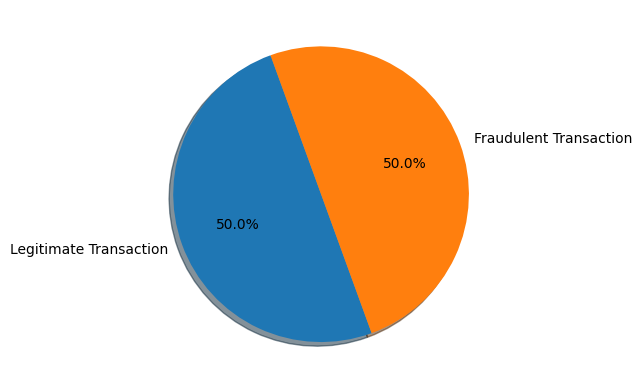

In [ ]:
def plot_data_imbalance(data_frame, target_column):
#     """
#     Display a pie chart to illustrate the class imbalance in the target column.

#     :param data_frame: The DataFrame containing the data.
#     :param target_column: The name of the target column for which the imbalance should be illustrated.
#     """
    if target_column not in data_frame.columns:
        raise ValueError(f"Target column '{target_column}' not found in the DataFrame.")

    class_counts = data_frame[target_column].value_counts()

    class_counts_df = class_counts.reset_index()
    class_counts_df.columns = [target_column, 'Count']

    labels = ["Legitimate Transaction" if x == 0 else "Fraudulent Transaction" for x in class_counts_df['TX_FRAUD_SCENARIO']]

    plt.pie(class_counts_df['Count'], labels=labels, autopct='%1.1f%%', shadow=True, startangle=110)
    plt.show()

# Call the function to display the class imbalance in the 'TX_FRAUD_SCENARIO' column
plot_data_imbalance(balanced_df, 'TX_FRAUD_SCENARIO')

In [ ]:
# Standardize the features (important for models like Logistic Regression and KNN)
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)

In [ ]:
def get_accuracy(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [ ]:
log_reg = LogisticRegression()
print(f"Logistic Regression accuracy: {get_accuracy(log_reg, X_resampled, X_test, y_resampled, y_test):.3f}")

Logistic Regression accuracy: 0.952


In [ ]:
knn = KNeighborsClassifier()
print(f"K-Nearest Neighbors accuracy: {get_accuracy(knn, X_resampled, X_test, y_resampled, y_test):.3f}")

K-Nearest Neighbors accuracy: 0.968


In [ ]:
decision_tree = DecisionTreeClassifier()
print(f"Decision Tree accuracy: {get_accuracy(decision_tree, X_resampled, X_test, y_resampled, y_test):.3f}")

Decision Tree accuracy: 0.967


In [ ]:
random_forest = RandomForestClassifier()
print(f"Random Forest accuracy: {get_accuracy(random_forest, X_resampled, X_test, y_resampled, y_test):.3f}")

Random Forest accuracy: 0.995


In [ ]:
gradient_boosting = GradientBoostingClassifier()
print(f"Gradient Boosting accuracy: {get_accuracy(gradient_boosting, X_resampled, X_test, y_resampled, y_test):.3f}")

Gradient Boosting accuracy: 0.995


In [ ]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')
print(f"XGBoost accuracy: {get_accuracy(xgb_model, X_resampled, X_test, y_resampled, y_test):.3f}")

XGBoost accuracy: 0.995
